# DQN Extensions

In [ ]:
# This project aims in implementation of DQN extension such as DDQN, Duelling DDQN and Prioritized Replay Buffer
# for SpaceInvaders Environment from MinAtar package.

# Package Installation

In [1]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.9 MB/s eta 0:00:00


# Imports

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

# Model Network

In [3]:
class Duelling_DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(Duelling_DQN, self).__init__()

        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride = 1)

        self.linear = nn.Linear(16*6*6, 256)

        self.value = nn.Linear(256, 1)
        self.advantage = nn.Linear(256, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear(x))

        value = self.value(x)
        advantage = self.advantage(x)

        q_value = value + advantage - torch.sum(advantage)/self.action_num

        return q_value


# Action Selection Policy

In [4]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

# Linear Decay for Hyperparameters - Epsilon, Alpha, Beta

In [5]:
def linear_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

# PrioritizedReplayBuffer

In [6]:
from collections import deque

class PrioritizedReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.max_size = max_size
        self.data = deque(maxlen=max_size)
        self.priorities = deque(maxlen=max_size)
        self.position = 0
        self.max_priority = 1

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def get_probabilities(self, alpha):
        # Probability(i) = (priority(i)^alpha)/(Sum(priority(i)^alpha))
        # Priority could have approximation errors, so to address this we use alpha;
        # alpha=0.0 becomes Pure Random sampling
        # alpha=1.0 becomes Pure prioritized random sampling

        priorities_tensor = torch.tensor(self.priorities, dtype=torch.float32)
        scaled_priorities = torch.pow(priorities_tensor, alpha)
        probabilities = scaled_priorities / torch.sum(scaled_priorities)
        return probabilities

    def set_priorities(self, indices, errors, offset=0.05):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

    def get_importance(self, probabilities, beta):
        # importance_weight corrects the bias introduced by not uniformly sampling during the neural network backward pass
        # importance_weight = ((1/N) * (1/Probability(i))) ^ Beta
        # Beta is a hyperparameter here; which similar to alpha, controls how much we want to prioritize

        N_length = len(self.data)
        importance_weight = (1/N_length) * (1/probabilities)
        scaled_importance_weight = torch.pow(importance_weight, beta)
        max_weight = torch.max(scaled_importance_weight) #To normalize
        return (scaled_importance_weight / max_weight)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        data = (obs, action, reward, next_obs, terminated)
        if len(self.data) < self.max_size:
            self.data.append(data)
            # Setting initial priorities - setting maximum priority in the buffer for new_experiences.
            # Generally done by getting max-priority. But max(priorities) selection when the buffer
            # gets large becomes computationally complex. So storing with constant max_priority for
            # the new experience, assuming any priority will not be more than this max_priority
            self.priorities.append(self.max_priority)  # Setting initial priorities
        else:
            self.data[self.position] = data
            self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int, alpha=1.0, beta=1.0) -> torch.Tensor:
        sample_probs = self.get_probabilities(alpha)
        # Sample batch of experiences based on probability value
        sample_indices = random.choices(range(len(self.data)), k=batch_size, weights=sample_probs)
        selected_samples = [self.data[i] for i in sample_indices]
        output = [torch.stack(b) for b in zip(*selected_samples)]
        importance = self.get_importance(sample_probs[sample_indices], beta)
        return output, sample_indices, importance

# Update Q Network

In [7]:
def update_ddqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        importance_weights: torch.Tensor,
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

    q_val = q(obs).gather(1, act.unsqueeze(1))

    mseloss = F.mse_loss(q_val, td_target)
    importance_weights_mean = importance_weights.mean()
    # Calculating weighted loss - considering errors of individual samples in loss
    weighted_loss = mseloss * importance_weights_mean

    weighted_loss.backward()
    optimizer.step()

    # Error is used to set the priority values for these experience
    error_batch =  torch.sub(q_val, td_target)
    error_batch = error_batch.detach()

    return error_batch


# Agent Creation

In [8]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class Duelling_DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            alpha=1.0,
            beta=1.0,
            buffer_hyperparam_eps_start = 1.0,
            buffer_hyperparam_eps_end = 0.1,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.alpha = alpha
        self.beta = beta
        self.buffer_param_start = buffer_hyperparam_eps_start
        self.buffer_param_end = buffer_hyperparam_eps_end

        self.buffer = PrioritizedReplayBuffer(maxlen)
        self.q = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        for params in self.q_target.parameters():
            params.requires_grad = False


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        epsilon = self.eps_start
        alpha = self.alpha
        beta = self.beta

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f} Alpha: {alpha:.3f} Beta: {beta:.3f}')

            obs, _ = self.env.reset()

            for episode_time in itertools.count():

                epsilon = linear_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                alpha = linear_decay(self.buffer_param_start, self.buffer_param_end, current_timestep, self.schedule_duration)
                beta = linear_decay(self.buffer_param_start, self.buffer_param_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(int(terminated))
                )

                data, sample_indices, importance = self.buffer.sample(self.batch_size, alpha, beta)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = data

                # Update the Q network
                batch_errors = update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch,
                    importance
                )

                # Set prirority of experience based on errors returned from Update step
                self.buffer.set_priorities(sample_indices, batch_errors)

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

# Environment Creation

In [9]:
# Choose your environment
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)



# Setting Hyperparameter

In [10]:
# Hyperparameters
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 100 #500 #100
DISCOUNT_FACTOR = 0.99

# Priority Scaling Hyperparameter
ALPHA = 1.0 #0.5
# Importance Sampling weight hyperparameter
BETA = 1.0 #0.5
# Decaying Hyperparamteres of Prioritizied Replay Buffer
# Decay of alpha and beta gives slightly better results compared to
# constant(1.0) alpha and beta value
ALPHA_BETA_EPS_START = 1.0
ALPHA_BETA_EPS_END = 0.1

# Initialise Agent

In [11]:
# Train DQN
agent = Duelling_DDQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    alpha=ALPHA,
    beta=BETA,
    buffer_hyperparam_eps_start = ALPHA_BETA_EPS_START,
    buffer_hyperparam_eps_end = ALPHA_BETA_EPS_END,
)
stats = agent.train(NUM_EPISODES)

Episode 1 of 100  Time Step: 0  Epsilon: 0.500 Alpha: 1.000 Beta: 1.000
Episode 2 of 100  Time Step: 38  Epsilon: 0.499 Alpha: 0.998 Beta: 0.998
Episode 3 of 100  Time Step: 55  Epsilon: 0.498 Alpha: 0.997 Beta: 0.997
Episode 4 of 100  Time Step: 93  Epsilon: 0.497 Alpha: 0.994 Beta: 0.994
Episode 5 of 100  Time Step: 120  Epsilon: 0.496 Alpha: 0.993 Beta: 0.993
Episode 6 of 100  Time Step: 216  Epsilon: 0.494 Alpha: 0.987 Beta: 0.987
Episode 7 of 100  Time Step: 351  Epsilon: 0.489 Alpha: 0.979 Beta: 0.979
Episode 8 of 100  Time Step: 397  Epsilon: 0.488 Alpha: 0.976 Beta: 0.976
Episode 9 of 100  Time Step: 463  Epsilon: 0.486 Alpha: 0.972 Beta: 0.972
Episode 10 of 100  Time Step: 568  Epsilon: 0.483 Alpha: 0.966 Beta: 0.966
Episode 11 of 100  Time Step: 595  Epsilon: 0.482 Alpha: 0.964 Beta: 0.964
Episode 12 of 100  Time Step: 702  Epsilon: 0.479 Alpha: 0.958 Beta: 0.958
Episode 13 of 100  Time Step: 876  Epsilon: 0.474 Alpha: 0.948 Beta: 0.948
Episode 14 of 100  Time Step: 962  Epsi

# Results

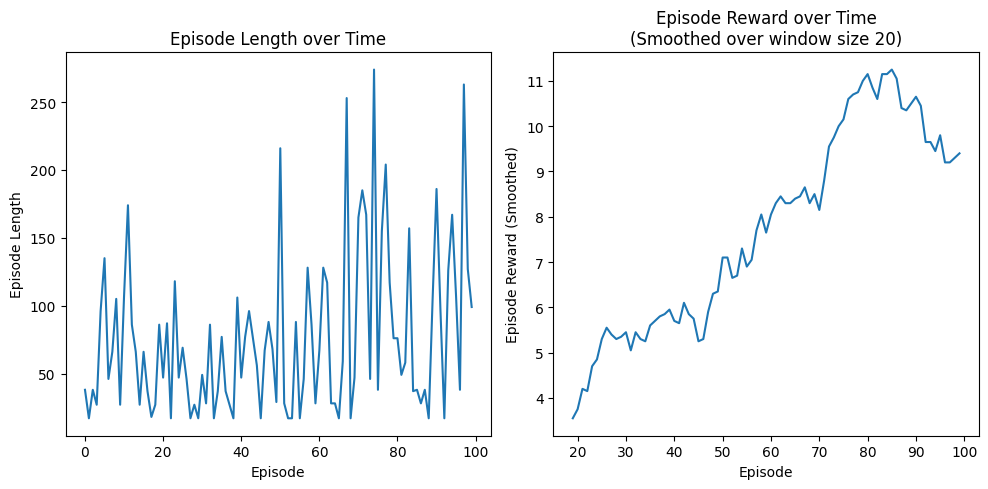

In [14]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

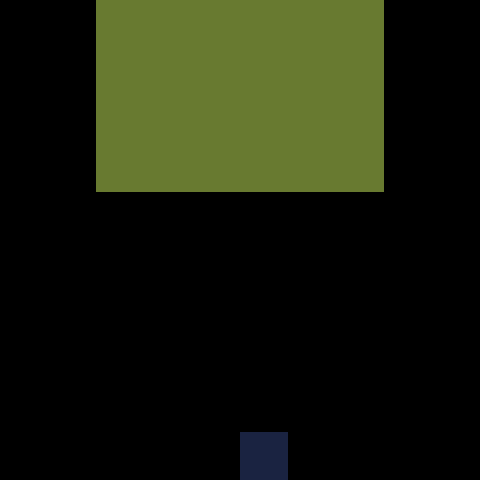

In [15]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")